# Prediction Bakery Turnover using AR-Net 
--------------------------------------------------------------------------------
### AR-Net (Autoregressive Neural Network developed by Triebe et al.)*
### Project by: Modeus Fawzy, Ravish Kumar
----------------------------------------------------------------

<img src="files/Overview.png">

In [46]:
import numpy as np
import pandas as pd
import os
import torch
import arnet
from arnet import ARNet
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
DIR = os.path.dirname(os.path.abspath(''))
data_path = os.path.join(DIR, 'ar_data')
results_dir = os.path.join(DIR, 'results')
if not os.path.exists(results_dir): 
    os.makedirs(results_dir)        

# AR-Net Model Definition
- Stands for Autoregressive Neural Network for time-series prediction
- Mimics the traditional AR process with a neural network
- Parameters of its first layer are equivalent to the AR-coefficients

### Learning AR-coefficients
- Fitting AR-Net model to objective function using MSE - as least squares in Classic-AR
- Optimization with stochastic gradient descent (SGD)
<img src="files/AR-Figure.png">

# Motaivtion
- Promoting explainability and simplicity that parallels classical time-series models with the added benefits of scalability

## Sparse AR-Net

- Relaxing the constraint of knowing the true AR order, by fitting a larger model with sparse AR coefficients
- Adding a regularization term to the loss function: λ(s)·R(θ)
- Will do away with the assumption that the AR-coefficients must consist of consecutive lags
- Sparsity factor is user-definied - Hyperparameters search

## Bakery Dataset - Task: Predicting Sales
### - Bakery Items: Bread, Rolls, Croissants, Pastry, Cake, Seasonal Bread -

<img src="files/Mini-Bakery.jpg">

# Data Preprocessing

               0
0     313.880911
1     262.363859
2     271.205024
3     254.247099
4     253.910761
...          ...
1657  224.609825
1658  276.453132
1659  200.656144
1660  207.147257
1661  237.924020

[1662 rows x 1 columns]


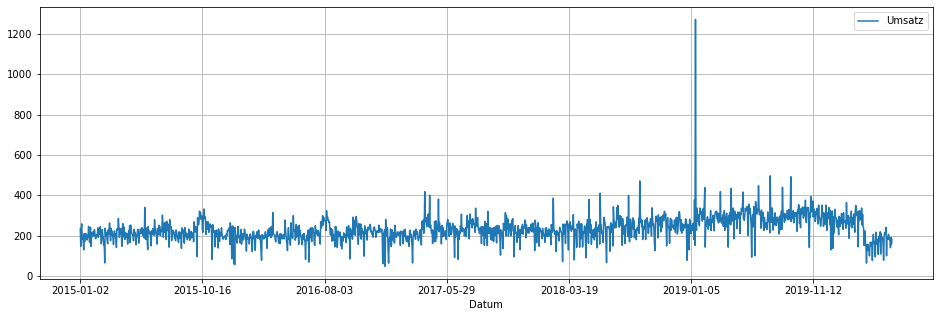

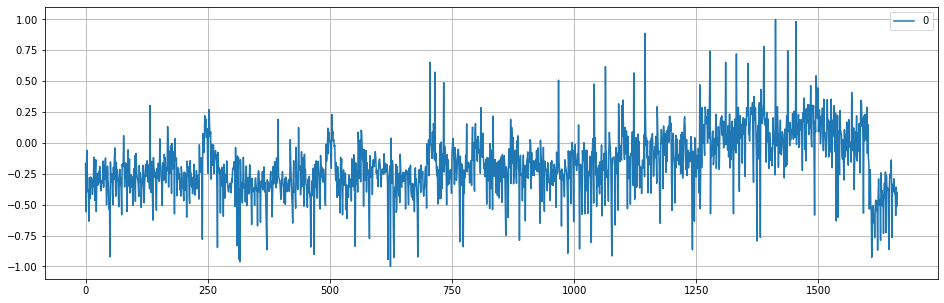

In [48]:
df = pd.read_csv('bakery_turnover.csv', index_col=0) # bakery turnover dataset

Bread = 1 
Rolls = 2 
Croissants = 3 
Pastry = 4 
Cake = 5 
Seasonal_bread = 6

bakery_items = ['Bread', 'Rolls', 'Croissants', 'Pastry', 'Cake']
ba_max = []
ba_min = []

for i, row in enumerate(bakery_items):
    bt = df[df.Warengruppe == i+1]
    ba = bt.drop(columns=['Warengruppe'])
    if i ==2: # croissants time-series
        ba.plot(figsize = (16,5), grid = True) # Sample Data Visualization
    
    #replace the single most max value (outlier) with mean
    ba = ba['Umsatz']
    bn = ba.to_numpy()
    bn[np.where(bn==np.max(bn))] = np.mean(bn)
    ba = pd.DataFrame(bn)
    
    #ba.to_csv(os.path.join(data_path, row +'.csv'), index=False) # save to file
    
    #Normalizing to interval [-1, 1]
    norm=(2*((ba-ba.min())/(ba.max()-ba.min())))-1 
    if i == 2: # normalized croissants time-series
        norm.plot(figsize = (16,5), grid = True) # Sample Data Visualization
    
    norm.to_csv(os.path.join(data_path, row +'_norm.csv'), index=False) # save to file
    
    
    ba_max.append(ba.max())
    ba_min.append(ba.min())

print(ba)

# Configuring AR-Net Model

In [49]:
#Initialize Hyparameters' Settings
save = True
 
n_epoch = 10 # no. of Epochs
valid_p = 0.1 # Data partitioning for validation 10%
train_bs = 32 # Training batch size
valid_bs = 64 # Validation batch size

In [71]:
# Create and Compile Model

def run(item, ar_order, sparsity):
    print("fitting: {} with ar_order: {}, sparsity: {}".format(item, ar_order, sparsity))
    df = pd.read_csv(os.path.join(data_path, item + '_norm.csv'))
    

    m = arnet.ARNet(
        ar_order=ar_order,
        sparsity=sparsity,
        n_epoch=n_epoch,
        loss_func="MSE",
        valid_p=valid_p,
        train_bs=train_bs,
        valid_bs=valid_bs,
        use_gpu=False,
    )
    m.fit(df, plot=True)

    if save:
        num_obs = 200
        preds, y = m.learn.get_preds()
        
        preds = preds[0:num_obs]
        actuals = y[0:num_obs]
        
        m.plot_fitted_obs()
        
    print("DONE with {}".format(item))
    return {"item:": item, "ar:": ar_order, "sparsity:": sparsity, 
            "predictions": preds.numpy(), "actuals": actuals.numpy()}


## A Set of Hyperparameters (AR Order, Sparsity) using Grid Search
## + Fitting all Time-series to finding Universal Model-Settings (Multi-tasking approach)
<img src="files/searchresults.png">

## + Training our Model to each Bakery Item (Time-series) separately

In [72]:
experiments = [(50, 0.3), (70, 0.5)] #(ar_order, sparsity) 
#[(50, 0.3), (70, 0.3), (90, 0.3), (110, 0.3), (50, 0.3), (70, 0.3), (90, 0.5), (110, 0.5), ....]

INFO: ARNet - tabularize: estimated noise of series: 0.20376952991906125


fitting: Bread with ar_order: 50, sparsity: 0.3


INFO: ARNet - create_regularizer: reg lam (max): 0.023333333255555557


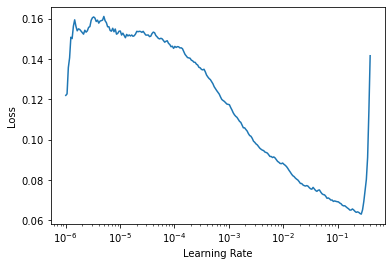

INFO: ARNet - find_lr: Optimal learning rate: 0.027331700921058653


epoch,train_loss,valid_loss,mse,mae,time
0,0.075586,0.092313,0.092313,0.239886,00:00
1,0.055758,0.068075,0.068075,0.204090,00:00
2,0.049276,0.071171,0.071171,0.202950,00:00
3,0.048745,0.065938,0.065938,0.192355,00:00
4,0.047296,0.062337,0.062337,0.188290,00:00
5,0.047119,0.063623,0.063623,0.195365,00:00
6,0.045143,0.062157,0.062157,0.185557,00:00
7,0.043332,0.062922,0.062922,0.189292,00:00
8,0.042780,0.063068,0.063068,0.191202,00:00
9,0.042268,0.063038,0.063038,0.189762,00:00


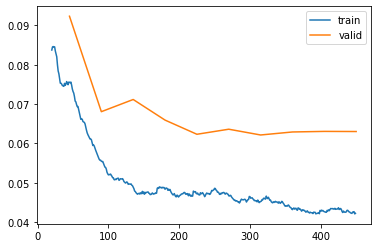

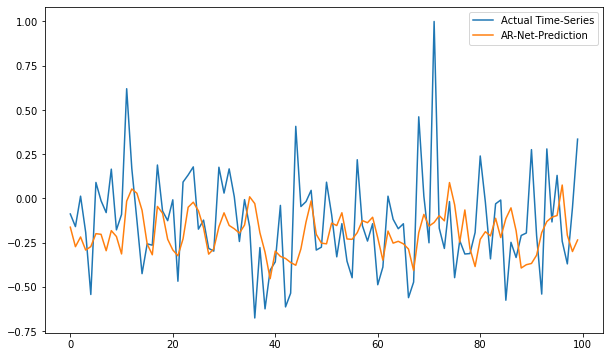

INFO: ARNet - tabularize: estimated noise of series: 0.167577277257479


DONE with Bread
fitting: Rolls with ar_order: 50, sparsity: 0.3


INFO: ARNet - create_regularizer: reg lam (max): 0.023333333255555557


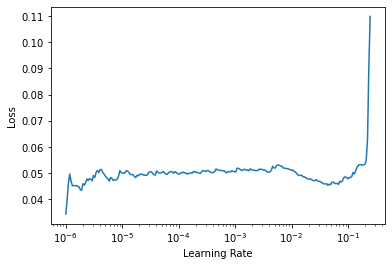

INFO: ARNet - find_lr: Optimal learning rate: 0.004398791119456291


epoch,train_loss,valid_loss,mse,mae,time
0,0.048704,0.095236,0.095236,0.244953,00:00
1,0.045668,0.055989,0.055989,0.191138,00:00
2,0.041383,0.049321,0.049321,0.178322,00:00
3,0.040002,0.038822,0.038822,0.157930,00:00
4,0.038667,0.036145,0.036145,0.153109,00:00
5,0.037831,0.037034,0.037034,0.154285,00:00
6,0.037002,0.033078,0.033078,0.146350,00:00
7,0.036266,0.035333,0.035333,0.151171,00:00
8,0.036070,0.033944,0.033944,0.148505,00:00
9,0.035539,0.034673,0.034673,0.149934,00:00


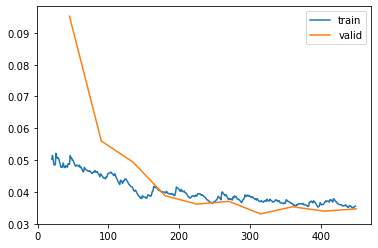

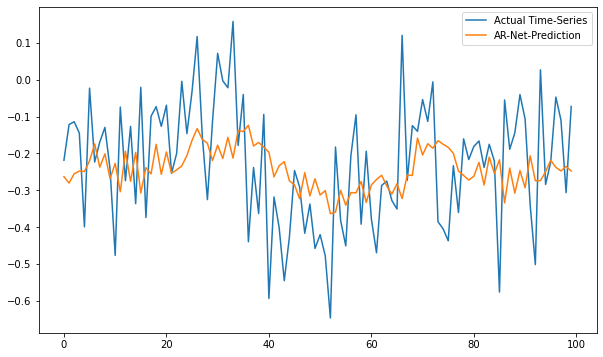

INFO: ARNet - tabularize: estimated noise of series: 0.18627425284012394


DONE with Rolls
fitting: Croissants with ar_order: 50, sparsity: 0.3


INFO: ARNet - create_regularizer: reg lam (max): 0.023333333255555557


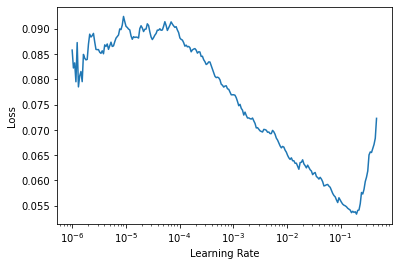

INFO: ARNet - find_lr: Optimal learning rate: 0.01980006694793701


epoch,train_loss,valid_loss,mse,mae,time
0,0.061082,0.078932,0.078932,0.215492,00:00
1,0.049358,0.043095,0.043095,0.152880,00:00
2,0.044909,0.047708,0.047708,0.164004,00:00
3,0.043123,0.040457,0.040457,0.152035,00:00
4,0.042124,0.044830,0.044830,0.156117,00:00
5,0.043751,0.043325,0.043325,0.156243,00:00
6,0.043495,0.041640,0.041640,0.154074,00:00
7,0.041766,0.041670,0.041670,0.149811,00:00
8,0.041104,0.041854,0.041854,0.151202,00:00
9,0.040963,0.042077,0.042077,0.151147,00:00


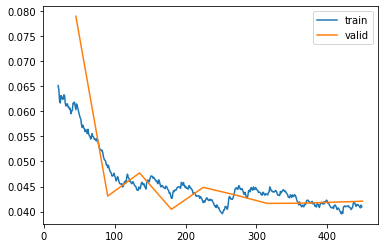

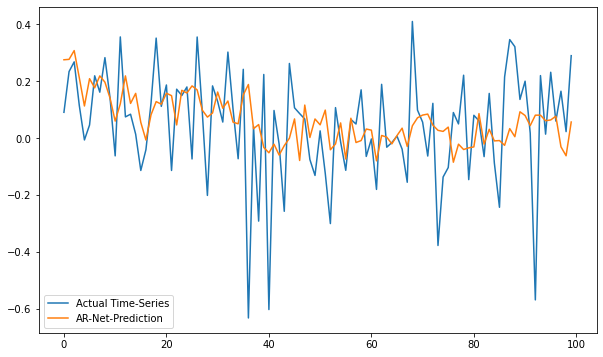

INFO: ARNet - tabularize: estimated noise of series: 0.18371491935813467


DONE with Croissants
fitting: Pastry with ar_order: 50, sparsity: 0.3


INFO: ARNet - create_regularizer: reg lam (max): 0.023333333255555557


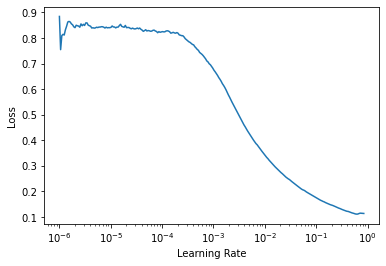

INFO: ARNet - find_lr: Optimal learning rate: 0.06118806004524231


epoch,train_loss,valid_loss,mse,mae,time
0,0.191421,0.040247,0.040247,0.158101,00:00
1,0.093380,0.025256,0.025256,0.124243,00:00
2,0.060865,0.023202,0.023202,0.118432,00:00
3,0.050735,0.023256,0.023256,0.120802,00:00
4,0.048342,0.042422,0.042422,0.166659,00:00
5,0.045715,0.022913,0.022913,0.117950,00:00
6,0.045628,0.022497,0.022497,0.116200,00:00
7,0.043288,0.023782,0.023782,0.117318,00:00
8,0.042584,0.025936,0.025936,0.127384,00:00
9,0.042333,0.024408,0.024408,0.123280,00:00


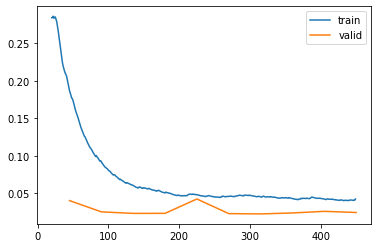

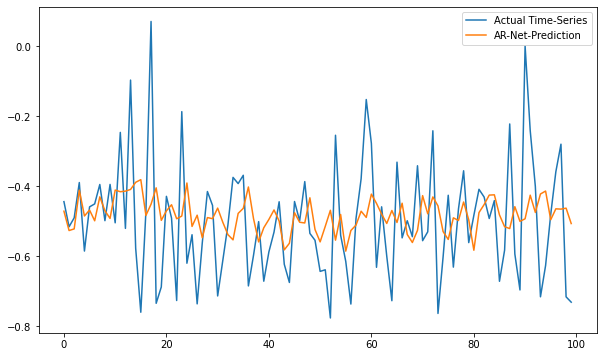

INFO: ARNet - tabularize: estimated noise of series: 0.09862311994398905


DONE with Pastry
fitting: Cake with ar_order: 50, sparsity: 0.3


INFO: ARNet - create_regularizer: reg lam (max): 0.023333333255555557


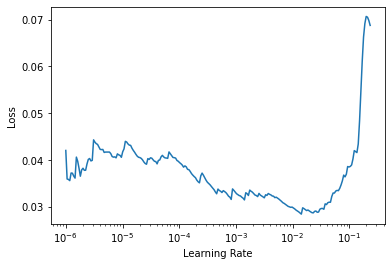

INFO: ARNet - find_lr: Optimal learning rate: 0.00142342085018754


epoch,train_loss,valid_loss,mse,mae,time
0,0.030832,0.054500,0.054500,0.148091,00:00
1,0.026247,0.051268,0.051268,0.144897,00:00
2,0.025555,0.049135,0.049135,0.139882,00:00
3,0.024612,0.046981,0.046981,0.135588,00:00
4,0.026008,0.045237,0.045237,0.131614,00:00
5,0.027087,0.045541,0.045541,0.136259,00:00
6,0.026854,0.044422,0.044422,0.126869,00:00
7,0.026163,0.042667,0.042667,0.125426,00:00
8,0.025727,0.042520,0.042520,0.125541,00:00
9,0.025382,0.042523,0.042523,0.125708,00:00


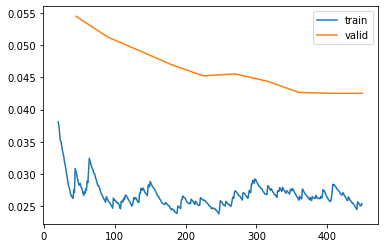

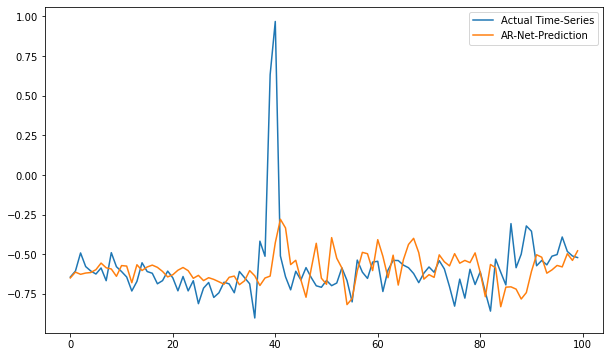

INFO: ARNet - tabularize: estimated noise of series: 0.20376952991906125


DONE with Cake
fitting: Bread with ar_order: 70, sparsity: 0.5


INFO: ARNet - create_regularizer: reg lam (max): 0.009999999980000004


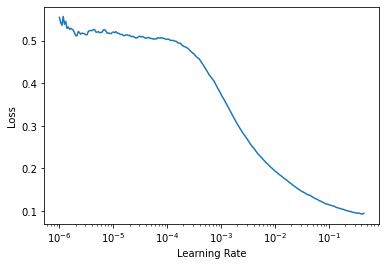

INFO: ARNet - find_lr: Optimal learning rate: 0.042008128762245175


epoch,train_loss,valid_loss,mse,mae,time
0,0.132428,0.092516,0.092516,0.234894,00:00
1,0.078714,0.074467,0.074467,0.212160,00:00
2,0.058938,0.073404,0.073404,0.215080,00:00
3,0.052703,0.077745,0.077745,0.221902,00:00
4,0.050876,0.064350,0.064350,0.192586,00:00
5,0.048148,0.065195,0.065195,0.196808,00:00
6,0.045895,0.065892,0.065892,0.192896,00:00
7,0.045217,0.068378,0.068378,0.194831,00:00
8,0.042581,0.063913,0.063913,0.192890,00:00
9,0.040774,0.064145,0.064145,0.193173,00:00


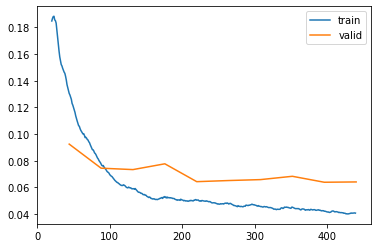

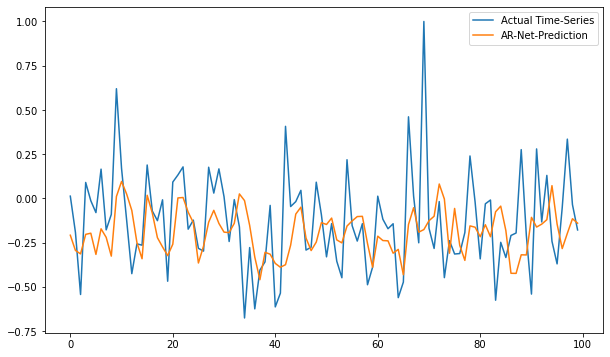

INFO: ARNet - tabularize: estimated noise of series: 0.167577277257479


DONE with Bread
fitting: Rolls with ar_order: 70, sparsity: 0.5


INFO: ARNet - create_regularizer: reg lam (max): 0.009999999980000004


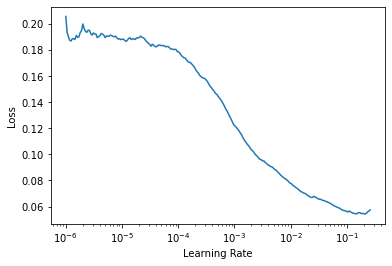

INFO: ARNet - find_lr: Optimal learning rate: 0.02089296132326126


epoch,train_loss,valid_loss,mse,mae,time
0,0.065994,0.058968,0.058968,0.200271,00:00
1,0.049726,0.040188,0.040188,0.163118,00:00
2,0.042025,0.038760,0.038760,0.157392,00:00
3,0.041091,0.054937,0.054937,0.189568,00:00
4,0.037615,0.030835,0.030835,0.139459,00:00
5,0.036452,0.037705,0.037705,0.155768,00:00
6,0.036697,0.031245,0.031245,0.140145,00:00
7,0.035738,0.032231,0.032231,0.142172,00:00
8,0.034614,0.035784,0.035784,0.151414,00:00
9,0.033314,0.034262,0.034262,0.147763,00:00


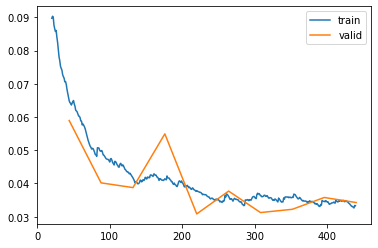

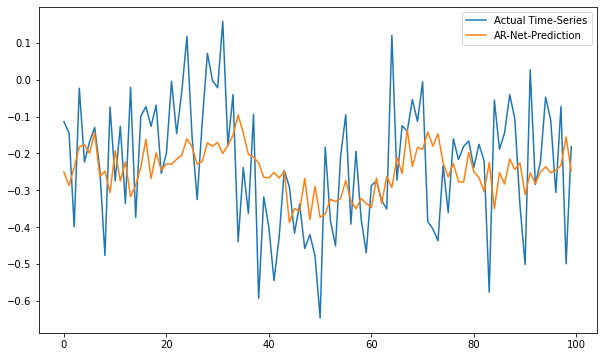

INFO: ARNet - tabularize: estimated noise of series: 0.18627425284012394


DONE with Rolls
fitting: Croissants with ar_order: 70, sparsity: 0.5


INFO: ARNet - create_regularizer: reg lam (max): 0.009999999980000004


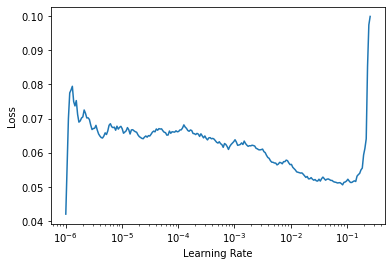

INFO: ARNet - find_lr: Optimal learning rate: 0.00838172361254692


epoch,train_loss,valid_loss,mse,mae,time
0,0.057240,0.080638,0.080638,0.213948,00:00
1,0.049167,0.048755,0.048755,0.163452,00:00
2,0.044581,0.043134,0.043134,0.152868,00:00
3,0.042120,0.044468,0.044468,0.155073,00:00
4,0.040701,0.046115,0.046115,0.158198,00:00
5,0.038772,0.045818,0.045818,0.157610,00:00
6,0.038893,0.045234,0.045234,0.156721,00:00
7,0.038977,0.045058,0.045058,0.155193,00:00
8,0.039007,0.044613,0.044613,0.154441,00:00
9,0.038799,0.045302,0.045302,0.155749,00:00


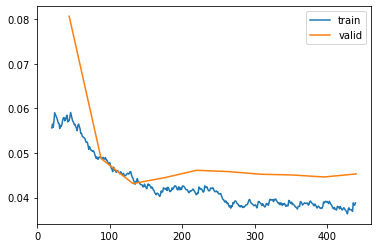

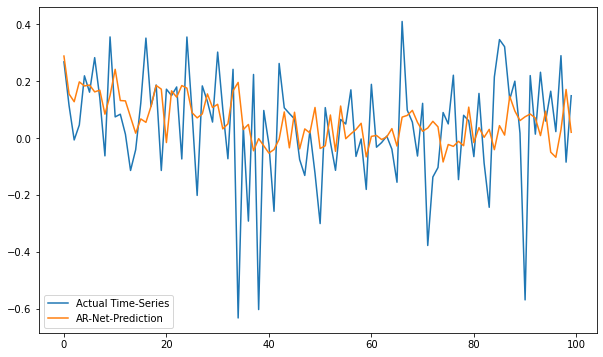

INFO: ARNet - tabularize: estimated noise of series: 0.18371491935813467


DONE with Croissants
fitting: Pastry with ar_order: 70, sparsity: 0.5


INFO: ARNet - create_regularizer: reg lam (max): 0.009999999980000004


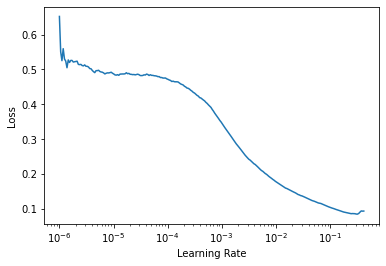

INFO: ARNet - find_lr: Optimal learning rate: 0.0321119487285614


epoch,train_loss,valid_loss,mse,mae,time
0,0.132732,0.033336,0.033336,0.142250,00:00
1,0.074233,0.031779,0.031779,0.145981,00:00
2,0.054654,0.026674,0.026674,0.133310,00:00
3,0.046471,0.023213,0.023213,0.120096,00:00
4,0.044084,0.023989,0.023989,0.118506,00:00
5,0.042893,0.022351,0.022351,0.116184,00:00
6,0.041476,0.023899,0.023899,0.122351,00:00
7,0.041155,0.023732,0.023732,0.121809,00:00
8,0.041105,0.024950,0.024950,0.126074,00:00
9,0.039020,0.023383,0.023383,0.120690,00:00


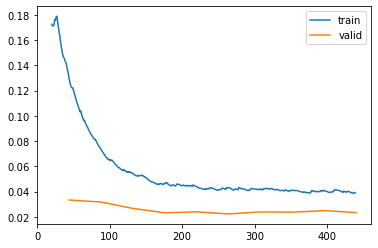

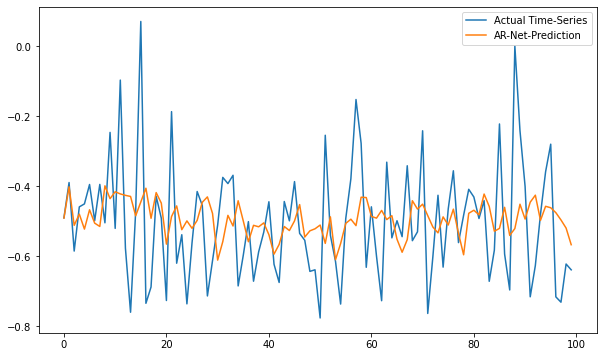

INFO: ARNet - tabularize: estimated noise of series: 0.09862311994398905


DONE with Pastry
fitting: Cake with ar_order: 70, sparsity: 0.5


INFO: ARNet - create_regularizer: reg lam (max): 0.009999999980000004


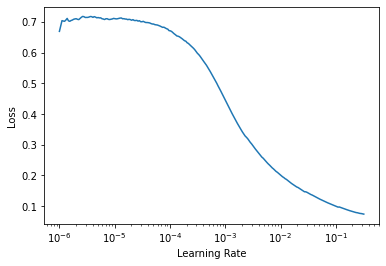

INFO: ARNet - find_lr: Optimal learning rate: 0.0321119487285614


epoch,train_loss,valid_loss,mse,mae,time
0,0.140379,0.090253,0.090253,0.210833,00:00
1,0.065268,0.050530,0.050530,0.140581,00:00
2,0.040139,0.043217,0.043217,0.119056,00:00
3,0.029343,0.038824,0.038824,0.108349,00:00
4,0.024179,0.035992,0.035992,0.103446,00:00
5,0.021860,0.034916,0.034916,0.100596,00:00
6,0.021586,0.038070,0.038070,0.125285,00:00
7,0.020497,0.033659,0.033659,0.100145,00:00
8,0.019526,0.034571,0.034571,0.109264,00:00
9,0.019049,0.033555,0.033555,0.103170,00:00


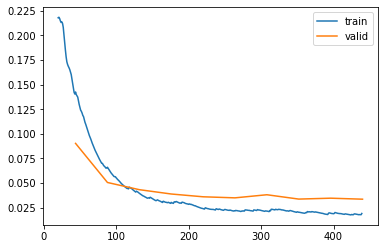

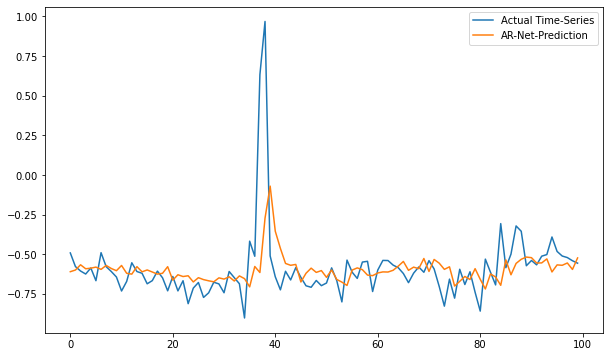

DONE with Cake
DONE


In [74]:
results_list = []

for ar_order, sparsity in experiments:
    for item in bakery_items:
        results_list.append(run(item, ar_order, sparsity))
        df_results = pd.DataFrame(results_list)
            
        if save:
            df_results.to_csv(os.path.join(results_dir, "results.csv"), index=False) # save results to file
print("DONE")


# Results
### Reversing Data Values to Unnormalized Form and Plotting Results

In [54]:
#retrieving max and min for each time-series and expanding the number of entries to match the entries in the search
ba_max = np.concatenate((ba_max, ba_max), axis=0) # ba_max = np.concatenate((ba_max, ba_max), axis=0)
ba_min = np.concatenate((ba_min, ba_min), axis=0) # ba_min = np.concatenate((ba_min, ba_min), axis=0)

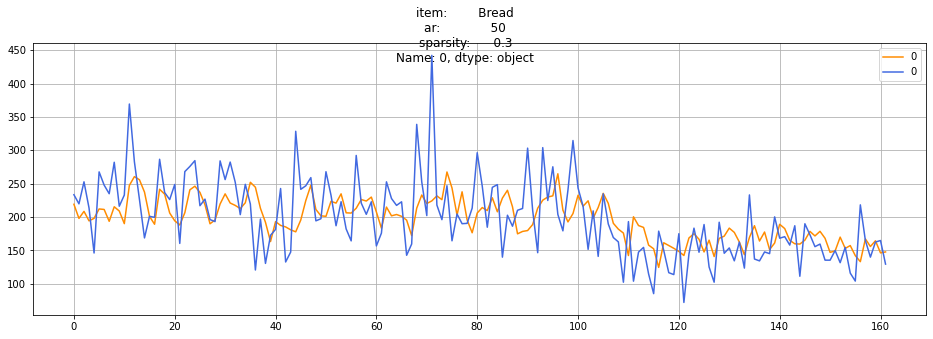

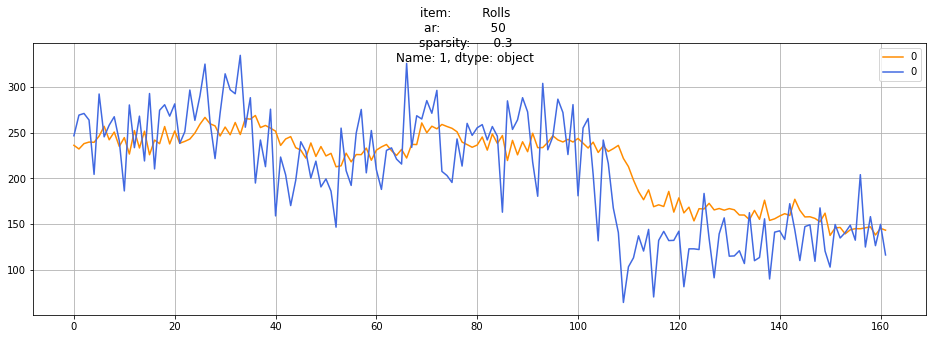

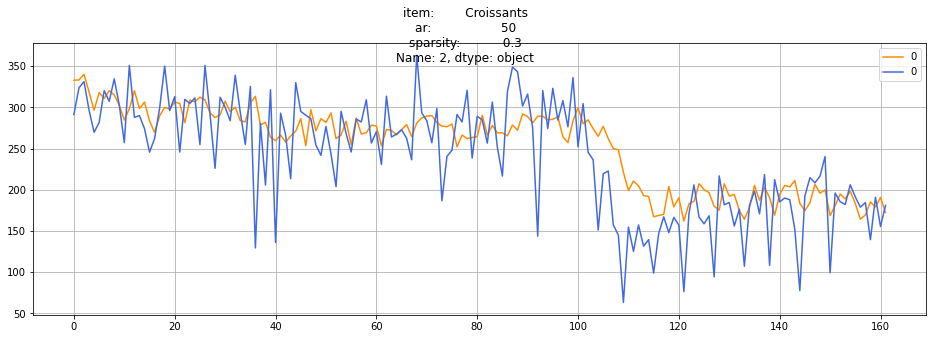

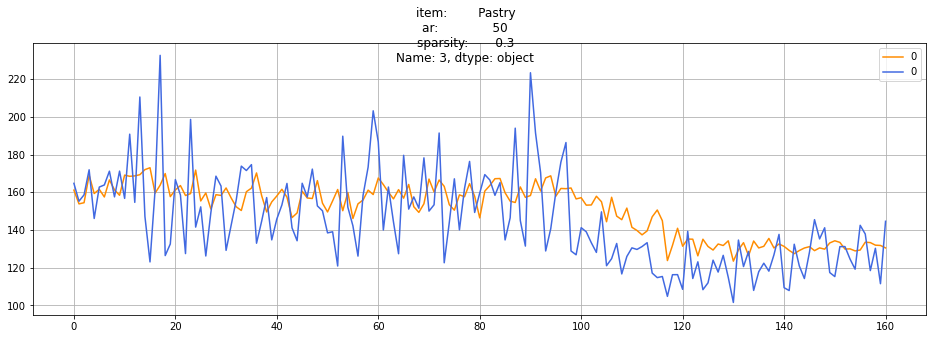

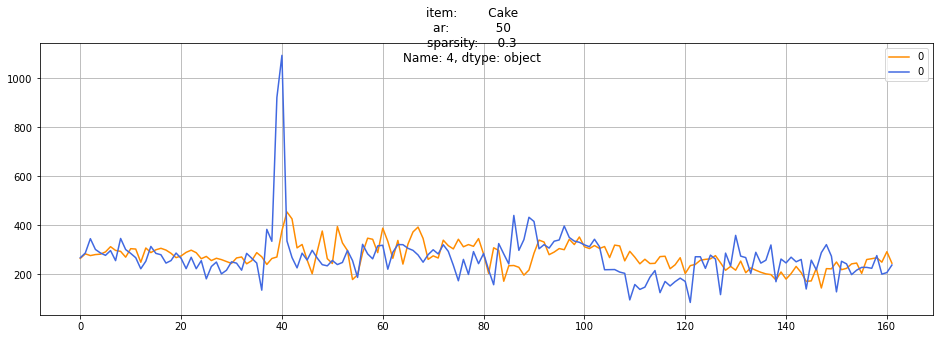

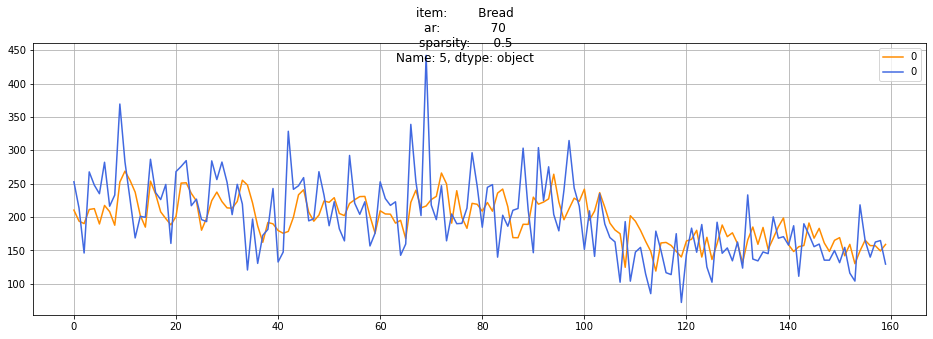

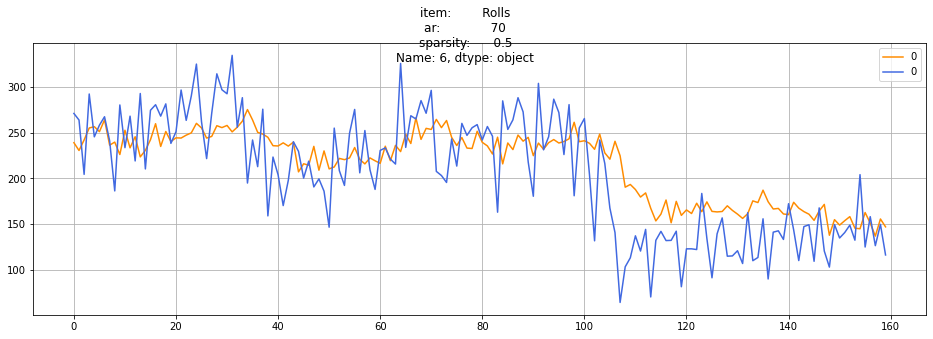

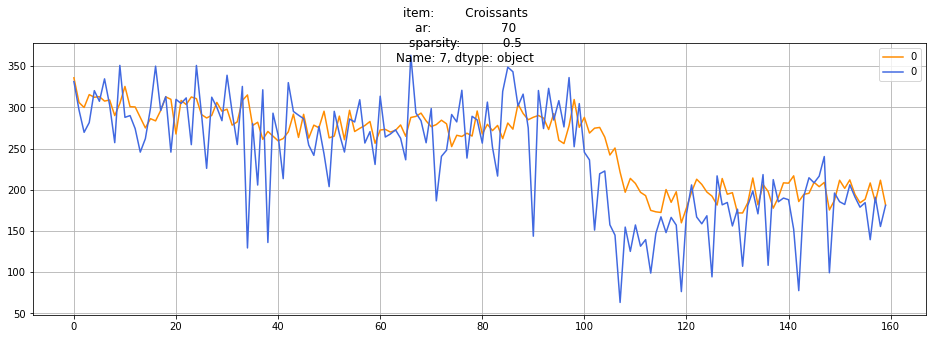

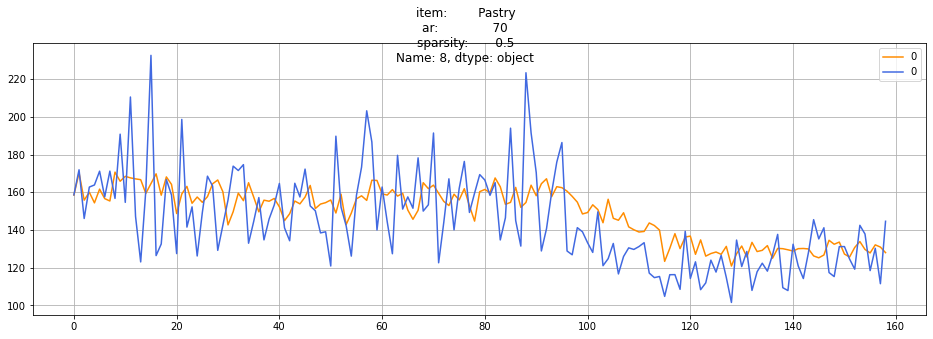

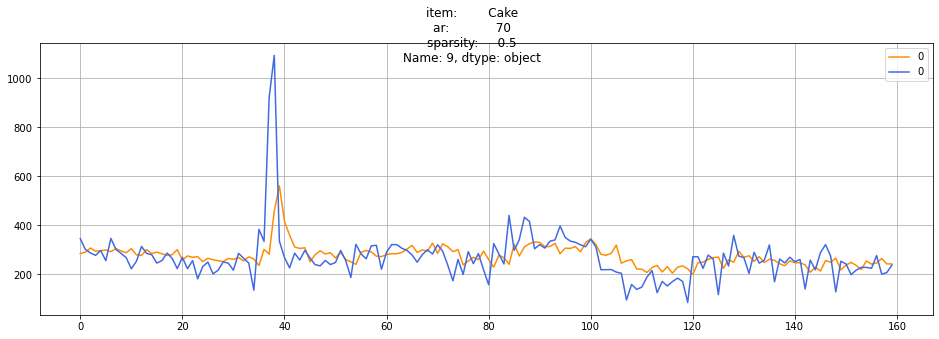

In [75]:
for i, row in df_results.iterrows():
    results = df_results[df_results.index == i]
    
    pred_df = results['predictions']
    pred_np = np.vstack(pred_df)
    predictions = pd.DataFrame(pred_np)
    px = (0.5*(predictions.to_numpy()+1)*(ba_max[i]-ba_min[i]))+(ba_min[i]) #Reversing normalized data to real values
    predictions = pd.DataFrame(px)
        
    actual_df = results['actuals']
    actual_np = np.vstack(actual_df)
    actuals = pd.DataFrame(actual_np)
    py = (0.5*(actuals.to_numpy()+1)*(ba_max[i]-ba_min[i]))+(ba_min[i]) #Reversing normalized data to real values
    actuals = pd.DataFrame(py)
    
    items = results['item:']
    ar = results['ar:']
    sparsity = results['sparsity:']
    frames = [items, ar, sparsity, predictions, actuals]
    result = pd.concat(frames)
    for it in items:
        if save:
            result.to_csv(os.path.join(results_dir, it+'.csv'), index=False) #save each result-time-series to file 
    
    fig, ax = plt.subplots()
    predictions.plot(figsize=(16, 5), color='darkorange', grid = True, ax=ax)
    actuals.plot(figsize=(16, 5), color='royalblue', grid = True, ax=ax)
    fig.suptitle("{}".format(row[0:3]), fontsize=12)
    plt.show()


# Future Work
- Include co-variate time-series and expanding the forecast horizon, all with the same model
- which expands analysis from univariate one-step forecasting to multivariate multi-step forecasting

### *  https://arxiv.org/pdf/1911.12436.pdf